# Autoencoder with tied weights

In this notebook, we build an autoencoder to reproduce the spectra with tied weights. This means, that the weights of the decoder part are the same as the weights from the encoder (symmetric architecture). One advantage is a decreased amount of trainable parameters, preventing the model from overfitting and increasing the speed of training. We are using the architecture from page 427 of the book "Hands-On Machine Learning with Scikit-Learn and Tensorflow" and adapt it to our data.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers

#importing the data
gen = np.loadtxt("qcs_gen10000.txt", delimiter=",")

#standard scaling the data
from sklearn.preprocessing import StandardScaler
gen = StandardScaler().fit_transform(gen)

#splitting data into train, validation and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(gen, test_size=0.2, random_state=42, shuffle=True, stratify=None)
train, val = train_test_split(train, test_size=0.2, random_state=42, shuffle=True, stratify=None)

In [14]:
import tensorflow as tf

n_inputs = train.shape[1]
n_hidden1 = 500
n_hidden2 = 200
n_hidden3 = 50
n_hidden4 = 10
n_hidden5 = n_hidden3
n_hidden6 = n_hidden2
n_hidden7 = n_hidden1
n_outputs = n_inputs

learning_rate=0.001
l2_reg = 0.0001

activation = tf.nn.elu

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
initializer=tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_hidden4])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")
weights5 = tf.transpose(weights4, name="weights3")
weights6 = tf.transpose(weights3, name="weights4")
weights7 = tf.transpose(weights2, name="weights4")
weights8 = tf.transpose(weights1, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_hidden4), name="biases4")
biases5 = tf.Variable(tf.zeros(n_hidden5), name="biases5")
biases6 = tf.Variable(tf.zeros(n_hidden6), name="biases6")
biases7 = tf.Variable(tf.zeros(n_hidden7), name="biases7")
biases8 = tf.Variable(tf.zeros(n_outputs), name="biases8")

hidden1 = activation(tf.matmul(X, weights1)+biases1)
hidden2 = activation(tf.matmul(hidden1, weights2)+biases2)
hidden3 = activation(tf.matmul(hidden2, weights3)+biases3)
hidden4 = activation(tf.matmul(hidden3, weights4)+biases4)
hidden5 = activation(tf.matmul(hidden4, weights5)+biases5)
hidden6 = activation(tf.matmul(hidden5, weights6)+biases6)
hidden7 = activation(tf.matmul(hidden6, weights7)+biases7)
outputs = tf.matmul(hidden7,weights8) + biases8

reconstruction_loss = tf.reduce_mean(tf.square(outputs-X)) #MSE

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)
val_loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init=tf.global_variables_initializer()

In [15]:
n_epochs = 50
batch_size = 150
X_test= test
loss_train, loss_val=[]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = train.shape[0] // batch_size
        for iteration in range(n_batches):
            X_batch = train[iteration*n_batches:iteration*n_batches+n_batches]
            sess.run(training_op, feed_dict={X: X_batch})
            loss_train.append(loss)
            loss_val.append()
    outputs_val = outputs.eval(feed_dict={X: X_test})

No handles with labels found to put in legend.


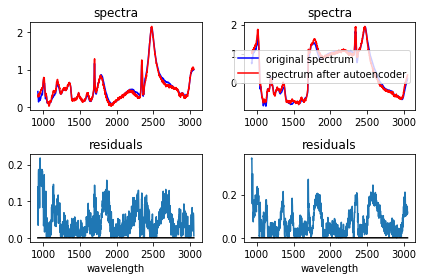

In [16]:
plots = 2
n_test = test.shape[0]
idx = np.random.choice(n_test, plots)
xaxis = np.linspace(929.52720343237377,3050.8548461203636,test.shape[1])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots)

for i in range(plots):
    ax1[i].plot(xaxis, test[idx[i]],'b', label="original spectrum")
    ax1[i].plot(xaxis, outputs_val[idx[i]], 'r', label="spectrum after autoencoder")
    ax1[1].legend()
    ax2[i].set_xlabel('wavelength')
    ax1[i].set_title("spectra")

    ax2[i].plot(xaxis, np.abs(test[idx[i]]-outputs_val[idx[i]]), label="residuals")
    ax2[i].plot(xaxis, np.zeros(xaxis.shape), 'k')
    
    ax2[i].set_title("residuals")
    
plt.tight_layout()
plt.show()

In comparison to the other autoencoder from the file autoencoder_spectra.ipynb, the above plots appear to be more accurate.

Note that we have also used ELU instead of tanh in this model. The number of layers and nodes is the same as in the other model.